In [214]:
import pointCollection as pc
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook
import re
import glob
import h5py

In [215]:
! rm /Volumes/ice2/ben/ATL14_test/IS2//U07/z03xlooser_dt10xlooser_80km/*mosaic.h5
! python3 ~/src/pointCollection/scripts/make_mosaic.py -d /Volumes/ice2/ben/ATL14_test/IS2//U07/z03xlooser_dt10xlooser_80km/ -g "*/*.h5" -G z0 -F z0  --feather 20000 --pad 10000 -O z0_mosaic.h5 -v
! python3 ~/src/pointCollection/scripts/make_mosaic.py -d /Volumes/ice2/ben/ATL14_test/IS2//U07/z03xlooser_dt10xlooser_80km/ -g "*/*.h5" -G dz -F dz count --feather 20000 --pad 10000 -O dz_mosaic.h5 -v

rm: cannot remove '/Volumes/ice2/ben/ATL14_test/IS2//U07/z03xlooser_dt10xlooser_80km/*mosaic.h5': No such file or directory


In [216]:
run_dir='/Volumes/ice2/ben/ATL14_test/IS2//U07/z03xlooser_dt10xlooser_80km/'
thefile=run_dir+'dz_mosaic.h5'
#glob.glob(run_dir+'/centers/*.h5')[10]
with h5py.File(thefile,'r') as h5f:
    print(h5f['dz'].keys())

<KeysViewHDF5 ['count', 'dz', 't', 'x', 'y']>


In [217]:
z0=pc.grid.data().from_h5(run_dir+'/z0_mosaic.h5', group='z0', field_mapping={'z':'z0'})
dz=pc.grid.data().from_h5(run_dir+'/dz_mosaic.h5', group='dz', field_mapping={'z':'dz'})
N=pc.grid.data().from_h5(run_dir+'/dz_mosaic.h5', group='dz', field_mapping={'z':'count'})
#sigma_dz=pc.grid.data().from_h5(thefile, group='dz/sigma', field_mapping={'z':'dzdt_lag4'})


<IPython.core.display.Javascript object>


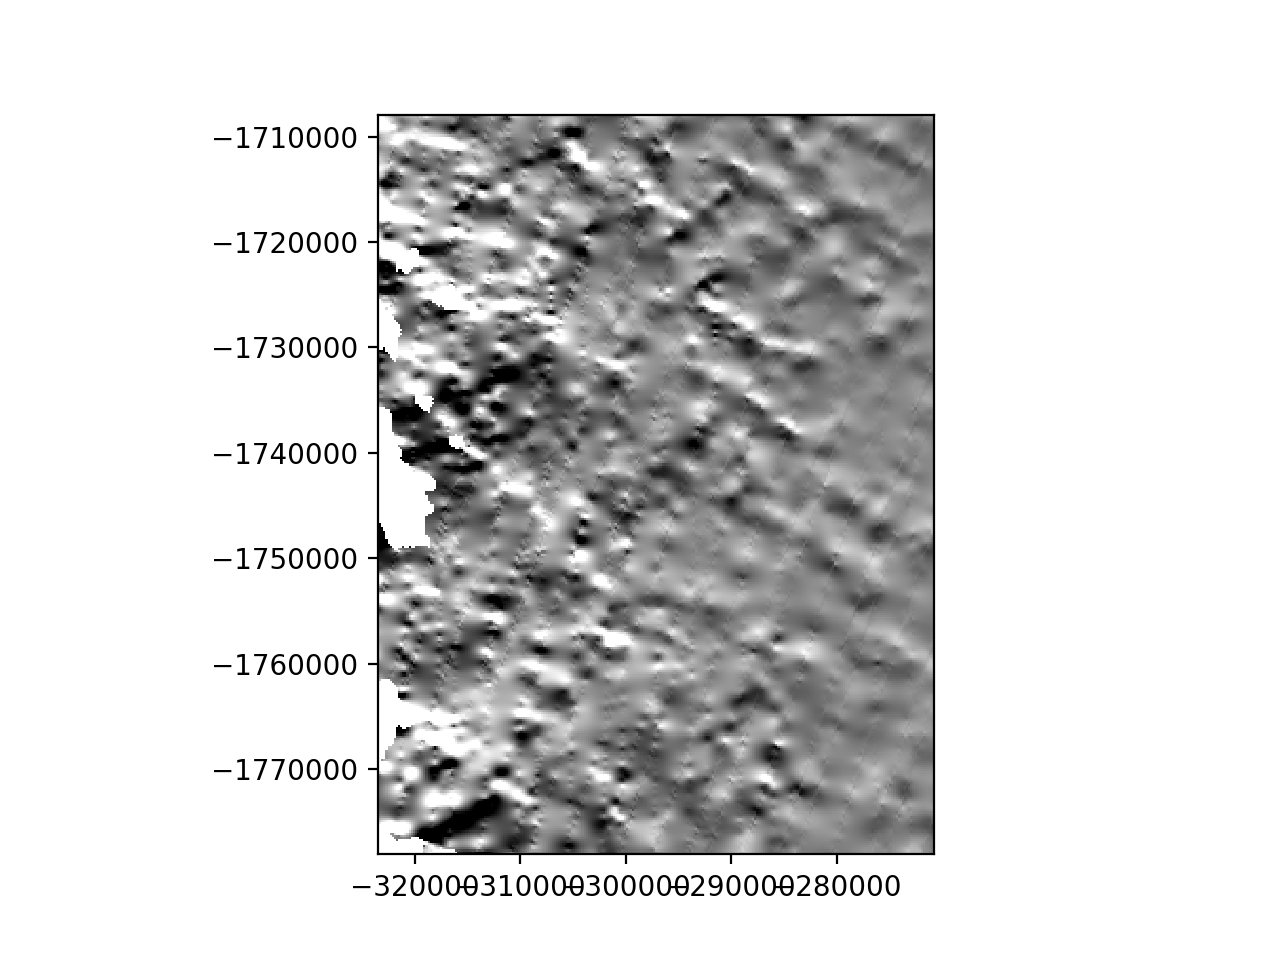

In [218]:
plt.figure(1); plt.imshow(np.gradient(z0.z[:,:,0])[0], extent=z0.extent, vmin=-10, vmax=10,  origin='lower',cmap='gray')

<IPython.core.display.Javascript object>


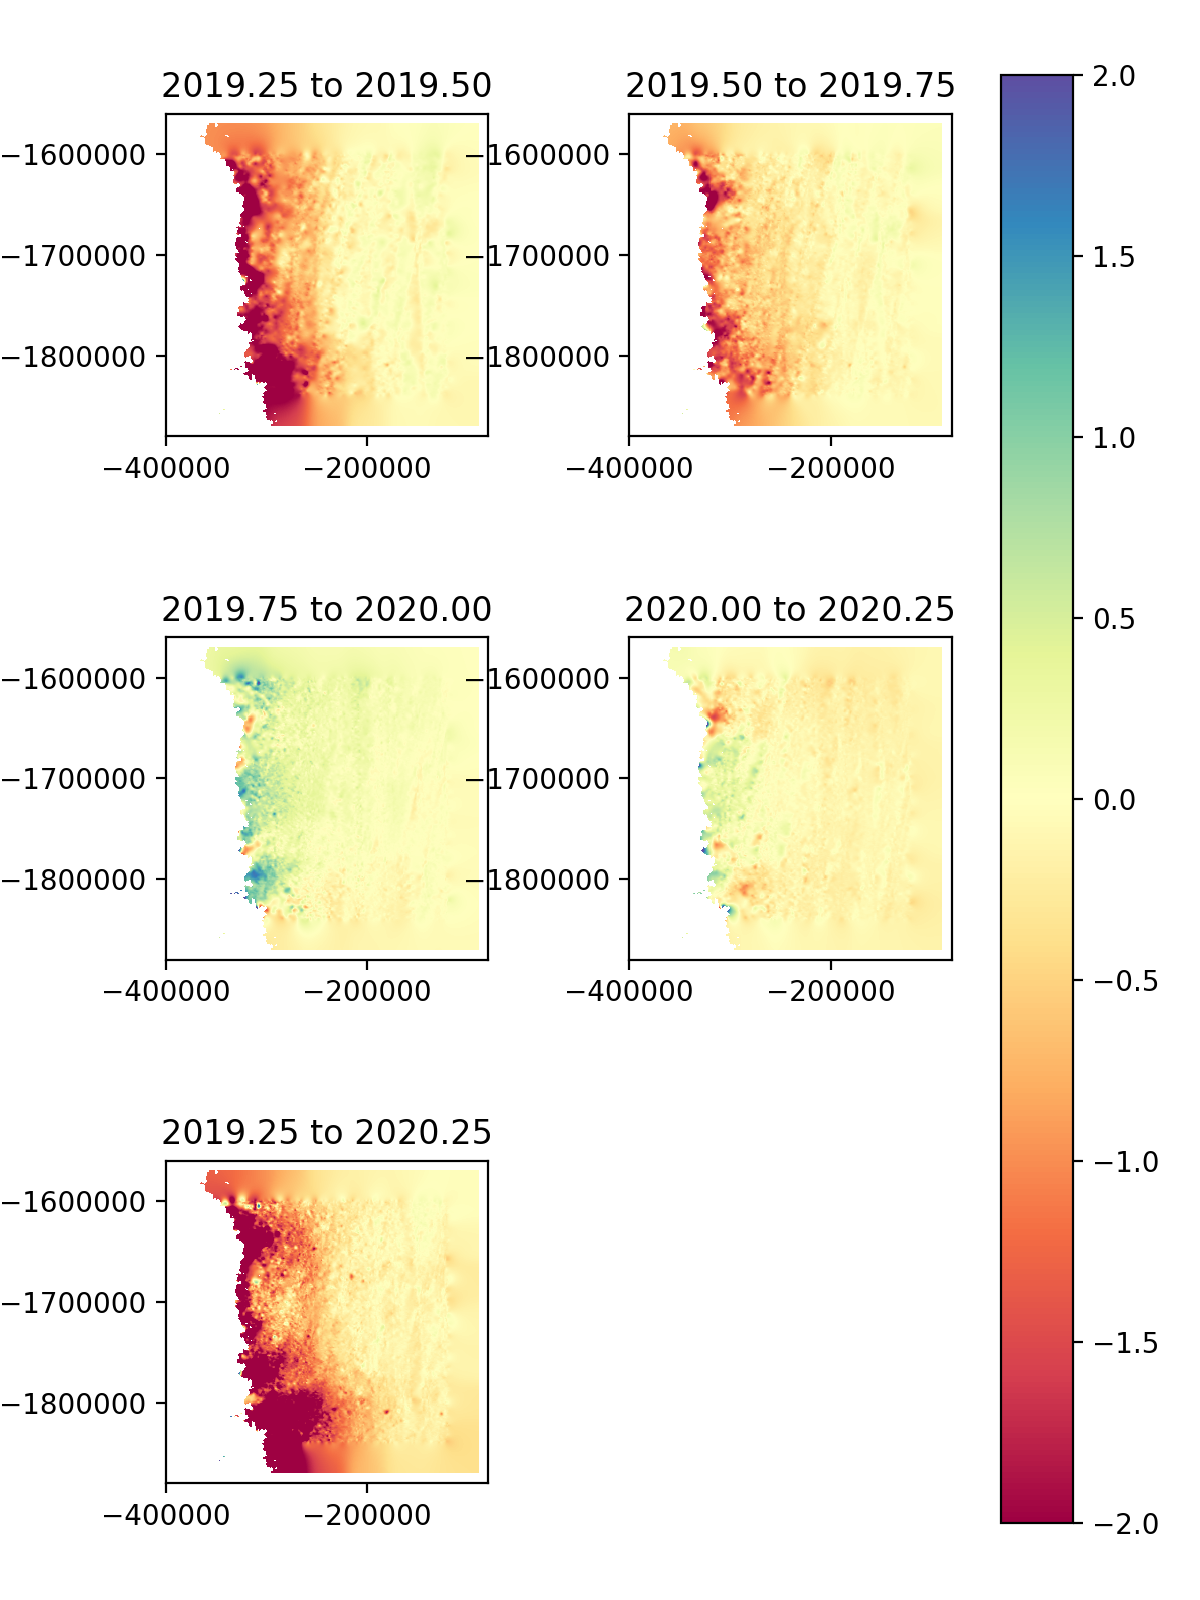

In [226]:
clim=2*np.array([-1, 1])
n_cols=np.ceil(np.sqrt(dz.shape[2]-2)).astype(int)
n_rows=np.ceil((dz.shape[2]-2)/n_cols).astype(int)+1
fig=plt.figure(2, figsize=[6, 8]); plt.clf()
h_im=[]
#h_ax=[]
fig, h_ax = plt.subplots(n_rows, n_cols, num=2)
for tslice in range(dz.shape[2]-2):
    axn=np.unravel_index(tslice, h_ax.shape)
    ax=h_ax[axn]
    #h_ax.append(fig.add_subplot(n_rows, n_cols, tslice+1))
    h_im.append(ax.imshow(dz.z[:,:,tslice+1]-dz.z[:,:,tslice], extent=dz.extent, origin='lower', cmap='Spectral', clim=clim))
    ax.set_title('%2.2f to %2.2f'% (dz.t[tslice], dz.t[tslice+1]))

axn=np.unravel_index(tslice+1, h_ax.shape)
ax=h_ax[axn]
h_im.append(ax.imshow(dz.z[:,:,tslice+1]-dz.z[:,:,0], extent=dz.extent, origin='lower', cmap='Spectral', clim=clim))
ax.set_title('%2.2f to %2.2f'% (dz.t[0], dz.t[tslice+1]))    

fig.tight_layout()
plt.colorbar(h_im[0], ax=h_ax)
h_ax[-1, -1].set_visible(False)


/Volumes/ice2/ben/ATL14_test/IS2//U07/z03xlooser_dt10xlooser_40km/centers/E-140_N-1800.h5


<IPython.core.display.Javascript object>


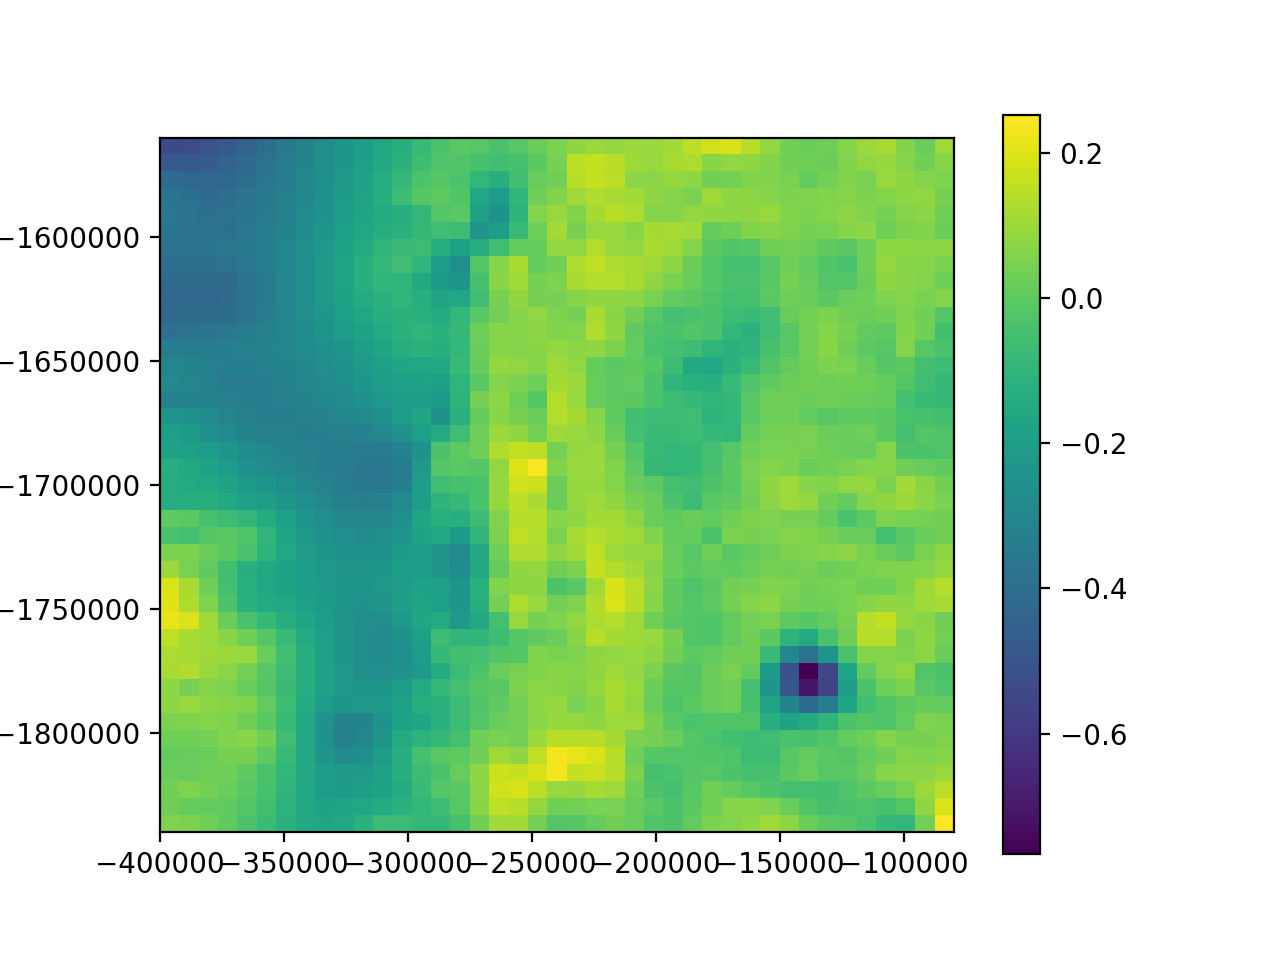

In [159]:
thefile=glob.glob(run_dir+'/*/E-140_N-1800.h5')[0]
print(thefile)
temp=pc.grid.data().from_h5(thefile, group='dz', field_mapping={'z':'dz'})
plt.figure();
plt.imshow(temp.z[:,:,3]-temp.z[:,:,0], origin='lower', extent=dz.extent); plt.colorbar()
#plt.imshow(np.nansum(temp.z>0, axis=2), origin='lower', extent=dz.extent); plt.colorbar()

<IPython.core.display.Javascript object>


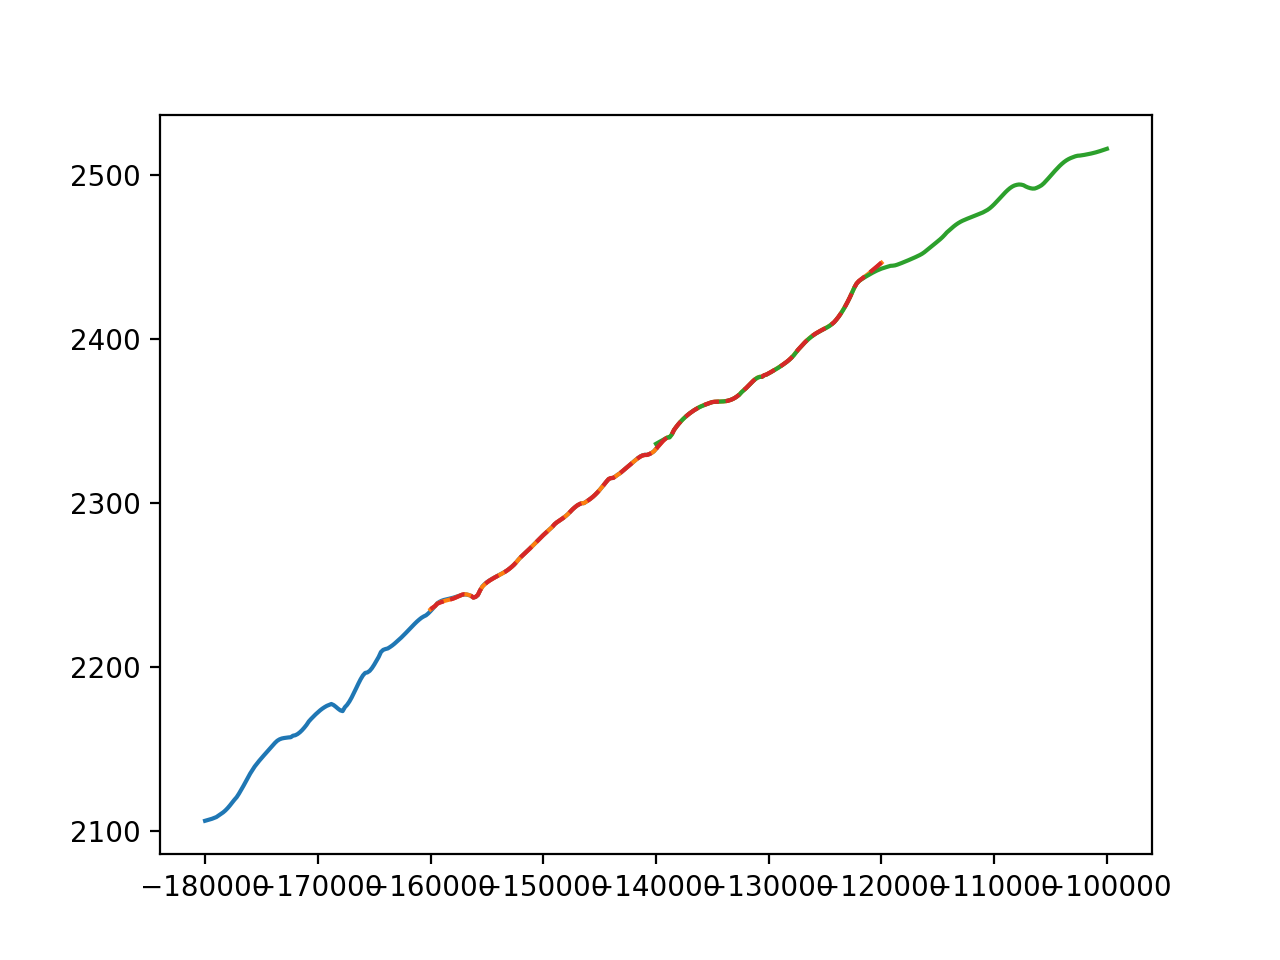

In [96]:
ctr_dir='/Volumes/ice2/ben/ATL14_test/IS2//U07/z03xlooser_dt10xlooser_40km/centers'
edge_dir='/Volumes/ice2/ben/ATL14_test/IS2//U07/z03xlooser_dt10xlooser_40km/edges'

c_files=['E-160_N-1800.h5',  'E-120_N-1800.h5']
fig=plt.figure(4)
fig.clf()
Dc={}
Bc={}
for file in c_files:
    Dc[file]=pc.grid.data().from_h5(ctr_dir+'/'+file, group='dz', field_mapping={'z':'dz'})
    with h5py.File(ctr_dir+'/'+file,'r') as h5f:
        Bc[file]={'rgt':np.array(h5f['/bias/rgt']),
           'cycle':np.array(h5f['/bias/cycle']),
           'val':np.array(h5f['/bias/val'])}
De={}
Be={}
for file in ['E-140_N-1800.h5']:
    De[file]=pc.grid.data().from_h5(edge_dir+'/'+file, group='dz', field_mapping={'z':'dz'})    
    with h5py.File(ctr_dir+'/'+file,'r') as h5f:
        Be[file]={'rgt':np.array(h5f['/bias/rgt']),
           'cycle':np.array(h5f['/bias/cycle']),
           'val':np.array(h5f['/bias/val'])}
    
for file in files:
    plt.plot(Dc[file].x, Dc[file].z[int(np.ceil(Dc[file].shape[0]/2)),:,2])

for file in ['E-140_N-1800.h5']:
    plt.plot(De[file].x, De[file].z[int(np.ceil(De[file].shape[0]/2)),:,2], '--')




In [98]:
fig=plt.figure(5)
fig.clf()
Dc0={}
for file in files:
    Dc0[file]=pc.grid.data().from_h5(ctr_dir+'/'+file, group='z0', field_mapping={'z':'z0'})
    
De0={}
for file in ['E-140_N-1800.h5']:
    De0[file]=pc.grid.data().from_h5(edge_dir+'/'+file, group='z0', field_mapping={'z':'z0'})    
  
for file in files:
    plt.plot(Dc0[file].x, Dc0[file].z[int(np.ceil(Dc0[file].shape[0]/2)),:])

for file in ['E-140_N-1800.h5']:
    plt.plot(De0[file].x, De0[file].z[int(np.ceil(De0[file].shape[0]/2)),:], '--')


In [88]:
len(rgts)

6

<IPython.core.display.Javascript object>


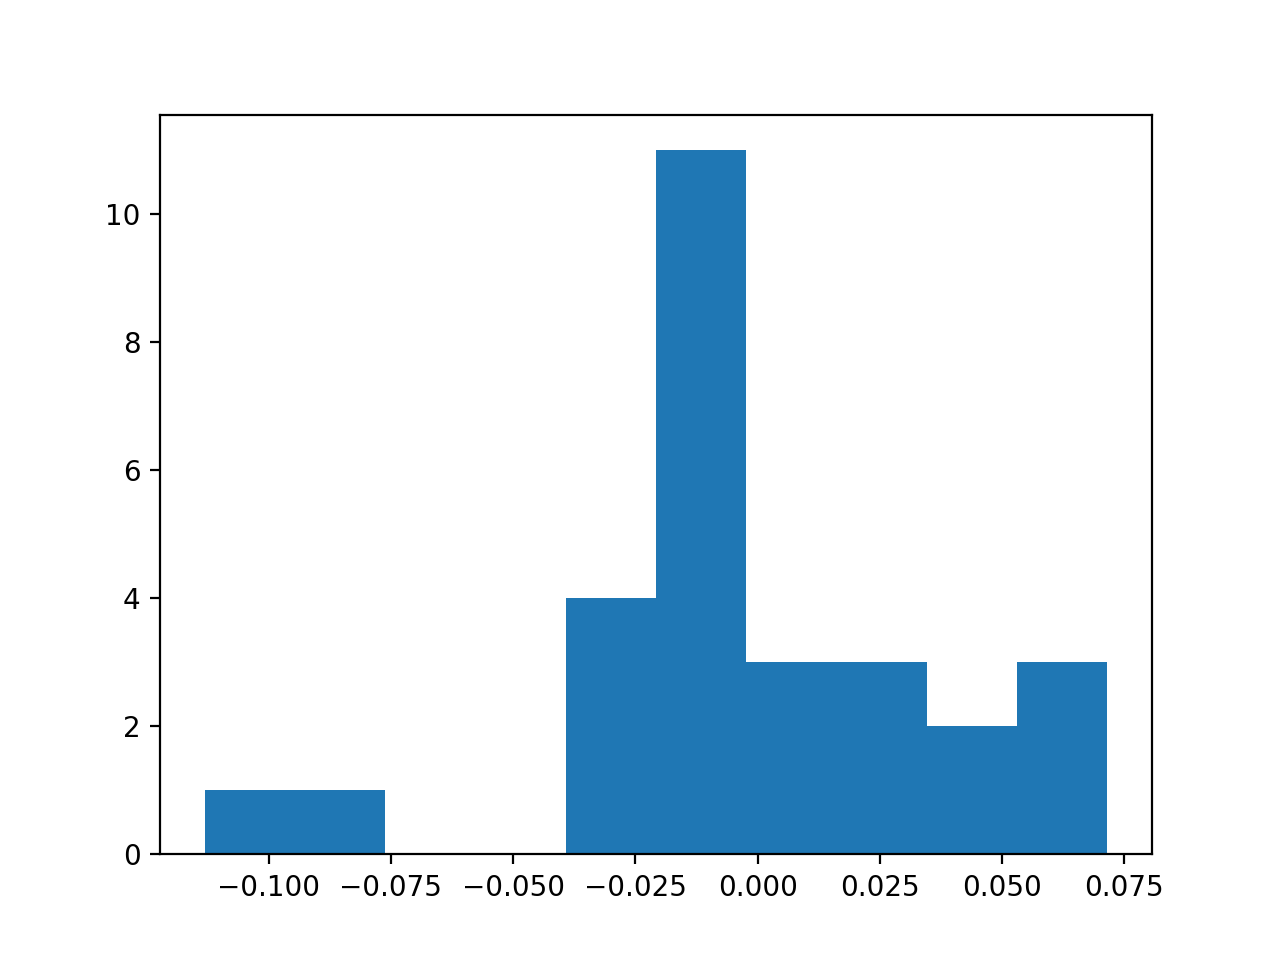

(array([ 1.,  1.,  0.,  0.,  4., 11.,  3.,  3.,  2.,  3.]),
 array([-0.11297002, -0.09453028, -0.07609053, -0.05765079, -0.03921105,
        -0.02077131, -0.00233156,  0.01610818,  0.03454792,  0.05298766,
         0.07142741]),
 <a list of 10 Patch objects>)

In [103]:
rc, ic, ie=np.intersect1d(Bc[files[2]]['rgt']+1j*Bc[files[2]]['cycle'], \
                          Be[files[1]]['rgt']+1j*Be[files[1]]['cycle'], return_indices=True)
fig=plt.figure(6); plt.clf()
plt.hist(Bc[files[2]]['val'][ic]-Be[files[1]]['val'][ie])
